# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
# устанавливаем библиотеку, чтобы скачать файл
!pip install wget

In [ ]:
# импортируем библиотки
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import wget

In [ ]:
# скачиваем файл при помощи wget
url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv'
filename = wget.download(url)

In [ ]:
# открываем файлик
df = pd.read_csv(filename, encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9629,15496,60448,"London, England",20-03-2020,@rightmove is warning the UK property market i...,Extremely Negative
7639,13074,58026,"Guwahati, India",20-03-2020,When the broke out businessmen doubled the pri...,Negative
10046,15994,60946,"Texas, USA",21-03-2020,My story about how a food delivery driver beca...,Positive
19101,27045,71997,"BHU,VARANASI",25-03-2020,@PMOIndia @narendramodi Sir!every food and med...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
# посмотрим, какие значения в целом есть в колонке sentiment
df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [ ]:
# делаем значения в колонке бинарными
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)

In [ ]:
# проверяем, что получилось
df.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
6446,11632,56584,NaN,19-03-2020,Will all the CEO and chief execs of companies ...,0
18544,26367,71319,"Dublin City, Ireland",25-03-2020,Coronavirus life tip #3: Commit to making 3 re...,1
9518,15358,60310,"37 Lower Bridge Street, Chester CH1 1RS",20-03-2020,What does the 3-month #coronavirus mortgage br...,1
8319,13908,58860,"Lima, OH",20-03-2020,"Lt. Gov. Husted: ""Come on people. We have to b...",1
32263,43483,88435,"Grangemouth, Falkirk East",13-04-2020,"IMPORTANT: Remember, if anyone in your househo...",1


Сбалансированы ли классы?

In [ ]:
# выводим количество значений каждого из классов
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** классы почти сбалансированы. Их соотношение (в процентах, округленное до целого числа) -- 54 и 46. Разница не очень большая, поэтому можно сказать, что они почти сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
# проверяем пропуски в данных
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

В колнке Location оказалось 7049 пропусков, заполним их строкой Unknown

In [ ]:
# меняем пропуски на unknown
df['Location'].fillna('Unknown', inplace=True)

In [ ]:
# проверим, что пропусков не осталось
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
# делим данные на обучающие и тестовые (сразу на X и y тоже)
from sklearn.model_selection import train_test_split

X = df.drop(['Sentiment'], axis=1)
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
# здесь будут все тексты из трейновой выборки, которые мы будем разбивать
texts = X_train['OriginalTweet']

In [ ]:
# в этом словаре будем хранить токены и их частоты встречаемости
tokens = {}
# проходимся по каждому тексту
for text in texts:
    # и токенизируем его
    # приводим к нижнему регистру и разбиваем по пробелам
    text = text.lower()
    tokens_text = text.split()
    # добавляем в словарь 1, если такого токена в словаре еще нет
    for token in tokens_text:
        if token not in tokens:
            tokens[token] = 1
    # или добавляем к значению в словаре 1
        else:
            tokens[token] += 1

Какой размер словаря получился?

In [ ]:
# выводим размер словаря
len(tokens)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
# сортируем словарь по частоте встречаемости токена и выводим 10 самых популярных
tokens_sorted = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
tokens_sorted[:10]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** в топе получились в основном "служебные слова" типа предлогов, артиклей или глаголов-связок. Это так называемый "шум", который встречается в любом тексте вне зависимости от его тематики или окраски, поэтому такие слова называются стоп-словами, а их нужно убирать. Также в топе оказался один хэштег: #coronavirus. Его присутствие в топе обуславливается тем, что в целом тексты про коронавирус, поэтому ожидаемо, что этот хэштег будет частотным.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
# скачаем из nltk стоп-слова для английского языка
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

sws = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# переделаем словарь: удалим стоп-слова из предыдущего
new_tokens = {token: tokens[token] for token in tokens if token not in sws}

In [ ]:
# сделаем сортировку и выведем топ-10 слов по частотности
new_tokens_sorted = sorted(new_tokens.items(), key=lambda x: x[1], reverse=True)
new_tokens_sorted[:10]

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  теперь в списке есть слова, которые выглядят как обычные слова английского языка. Но также есть два хэштега, опять-таки связанных с коронавирусом. А еще что-то непонятное на последнем месте: `&amp;` -- возможно, какой-то тег

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
# выведем 20 последних токенов из полученного выше словаря
new_tokens_sorted[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** здесь уже много всякого "мусора". Во-первых, есть непонятные ссылки вида https://t.co, во-вторых --по, видимому, упоминания каких-то людей, например, @680news. Также есть, например, "nothing...", где сохранились знаки препинания после слова.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
# импортируем новый токенайзер
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tokens_tw = {}
# токенизиурем каждый текст трейновой выборки
for text in texts:
    text = text.lower()
    tokens_text = tw.tokenize(text)
    for token in tokens_text:
        if token not in tokens_tw:
            tokens_tw[token] = 1
        else:
            tokens_tw[token] += 1

In [ ]:
# сортируем получившийся словарь и выводим топ-10
tokens_tw_sorted = sorted(tokens_tw.items(), key=lambda x: x[1], reverse=True)
tokens_tw_sorted[:10]

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** # помимо служебных слов (артиклей, предлогов) в список попала и пунктуация: точка, запятая, вопросительный знак. Потому что этот токенайзер отделяет знаки препинания от слов

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
# импортируем пунктуацию
from string import punctuation

# создаем новый список шума
noise = stopwords.words("english") + list(punctuation)

# новый словарь токенов
new_tokens_tw = {token:
                 tokens_tw[token] for token in tokens_tw if token not in noise}

In [ ]:
# снова сортировка и топ-10
new_tokens_tw_sorted = sorted(new_tokens_tw.items(), key=lambda x: x[1], reverse=True)
new_tokens_tw_sorted[:10]

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** помимо нормальных слов и хэшетгов появились какие-то странные символы на втором, третьем и седьмом местах

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
tokens_ord = {}
# удаляем односимвольные токены с позицией более 128
for token in new_tokens_tw:
    try:
        ord(token)
        if ord(token) >= 128:
            pass
        else:
            tokens_ord[token] = new_tokens_tw[token]
    except:
        tokens_ord[token] = new_tokens_tw[token]

In [ ]:
# снова сортировка и топ-10
tokens_ord_sorted = sorted(tokens_ord.items(), key=lambda x: x[1], reverse=True)
tokens_ord_sorted[:10]

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

Так как пунктуация отделяется от слов, тег #coronavirus-19 разделился на два токена. В остальном топ-10 получился хорошим!

In [ ]:
# 20 самых непопулярных слов
tokens_ord_sorted[-20:]

[('https://t.co/lw1r0rm7xs', 1),
 ('https://t.co/5cbliqzx7l', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** "анти-топ" 20 в целом похож на такой же в предыдущем задании, только слов с пукнтуацией на конце не осталось: остались ссылки и упоминания пользователей, а еще что-то странное вида "playersÃ", где не было пробела или другого знака между странным односимвольным знаком

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
# словарь хештегов
hashtags = {token: tokens_ord[token] for token in tokens_ord if token[0] == '#'}

In [ ]:
# топ-10 хештегов
hashtags_sorted = sorted(hashtags.items(), key=lambda x: x[1], reverse=True)
hashtags_sorted[:10]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** в основном все хештеги соотностся с тематикой твитов: везде сказано про пандемию, коронавирус, они очень частотны

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
# словарь ссылок
links = {token: tokens_ord[token] for token in tokens_ord if (token[:12] == 'https://t.co')}

In [ ]:
# топ-10
links_sorted = sorted(links.items(), key=lambda x: x[1], reverse=True)
links_sorted[:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** ссылки, по сравнению с хештегами, ужасно нечастотны, не несут какой-либо дополнительной информации информации



Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):
    # приводим к нижнему регистру
    text = text.lower()
    # используем tweettokenizer
    tw = TweetTokenizer()
    tokens_text = tw.tokenize(text)
    # удаляем "шум"
    tokens_text_sws = [token for token in tokens_text if token not in noise]
    tokens_ord = []
    # удаляем односимвольные токены с позицей больше 128
    for token in tokens_text_sws:
        try:
            ord(token)
            if ord(token) >= 128:
                pass
            else:
                tokens_ord.append(token)
        except:
            tokens_ord.append(token)
    # удаляем ссылки
    tokens = [token for token in tokens_ord if (token[:12] != 'https://t.co')]
    return tokens

In [ ]:
# проверяем работу
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
# импортируем countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

texts = list(X_train['OriginalTweet'])

In [ ]:
# обучаем countvectorizer с использованием нашего токенайзера и вводим размер словаря
import warnings
warnings.filterwarnings("ignore")

cv = CountVectorizer(tokenizer=custom_tokenizer)
X_vec = cv.fit_transform(texts)
print(len(cv.vocabulary_))

45308


**Ответ:** Размер в начале был: 79755. Размер стал: 45308. Получается, что размер уменьшился более чем на 30000 токенов! Видимо, большую часть этого словаря в начале занимали ссылки, шум, а также слова с пунктуацией (без пробела между словом и знаком препинания)

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
# выводим твит
ind = 9023
X_train.iloc[ind]['OriginalTweet'], y_train.iloc[ind]

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
# применяем countvectorizer
sent = cv.transform([X_train.iloc[ind]['OriginalTweet']])

In [ ]:
# делаем датафрейм
sent_df = pd.DataFrame(sent.toarray(), columns=cv.get_feature_names_out())

In [ ]:
# выводим часть датафрейма, где не нули
sent_df.loc[:, (sent_df != 0).any(axis=0)]

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** В качестве значений в таблице получились просто число упоминания слова в твите. Как мы видим, каждое из слов упоминалось только один раз, поэтому такой метод не позволяет нам говорить о том, какой токен самый важный или неважный

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
# делаем то же самое с тф-идф
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
X_tfidf = tfidf.fit_transform(texts)

In [ ]:
sent_tfidf = tfidf.transform([X_train.iloc[ind]['OriginalTweet']])

In [ ]:
sent_df_tfidf = pd.DataFrame(sent_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
sent_df_tfidf.loc[:, (sent_df_tfidf != 0).any(axis=0)]

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


**Ответ:** здесь мы уже полчили значения с учетом встречаемости слов во всех текстах в трейновой выборке. Поэтому значения лучше показывают, какой токен является более или менее важным. Например, в этом твите самым важным токеном оказывается brainless, что действительно указывает на негативную окраску твиту

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
# посмотрим на твиты со словом amazing, сделаем то же самое
amazing_sent = [X_train[X_train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (y_train == 1)].iloc[11]['OriginalTweet']]

In [ ]:
amazing_sent = tfidf.transform(amazing_sent)

In [ ]:
amazing_sent_tfidf = pd.DataFrame(amazing_sent.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
amazing_sent_tfidf.loc[:, (amazing_sent_tfidf != 0).any(axis=0)]

,19,amazing,cleaners,covid,delivery,drivers,front,like,line,many,nhs,patchwork,real,staff,superheroes,supermarket,thank,workers,working
0,0.090945,0.263351,0.291884,0.096494,0.184832,0.226258,0.230929,0.153432,0.21998,0.179588,0.240425,0.426786,0.230929,0.191787,0.375216,0.116797,0.194394,0.159474,0.193105


**Ответ:** значение, которое здесь получается у слова amazing, достаточно велико, по сравнению с другими словами. Поэтому можно сказать, что за счет этого относительно большого значения окраска этого твита будет определена как положительная

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
# разделим тексты на трейновые и тестовые
texts_tr = list(X_train['OriginalTweet'])
texts_ts = list(X_test['OriginalTweet'])

# применим countvectorizer
X_train_transformed_cv = cv.fit_transform(texts_tr)
X_test_transformed_cv = cv.transform(texts_ts)

# tidfvectorizer
X_train_transformed_ti = tfidf.fit_transform(texts_tr)
X_test_transformed_ti = tfidf.transform(texts_ts)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
# импортируем логистическую регрессию и accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

In [ ]:
# обучаем модель и делаем предсказания
lr.fit(X_train_transformed_cv, y_train)
lr_pred_test = lr.predict(X_test_transformed_cv)
lr_pred_train = lr.predict(X_train_transformed_cv)

acc_test = accuracy_score(y_test, lr_pred_test)
acc_train = accuracy_score(y_train, lr_pred_train)

# выводим для countvectorizer
print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9844510892780863
Доля правильных ответах на тесте: 0.8674506677297189


In [ ]:
# то же самое для tf-idf
lr.fit(X_train_transformed_ti, y_train)
lr_pred_test = lr.predict(X_test_transformed_ti)
lr_pred_train = lr.predict(X_train_transformed_ti)

acc_test = accuracy_score(y_test, lr_pred_test)
acc_train = accuracy_score(y_train, lr_pred_train)

print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9254592054677488
Доля правильных ответах на тесте: 0.8533984452860275


**Ответ:** Как можно заметить, countvectorizer отработал немного лучше: у него очень высокая accuracy на трейне, достаточно высокая на тесте. Но разница между значениями достаточно большая: модель скорее переобучилась. В случае tfidf разница между значениями гораздо меньше, переобучение заметно в меньшей мере. Но сами значения немного (в случае теста, много -- в случае трейна) меньше полученных при помощи countvectorizer

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
# импортируем стеммер
from nltk.stem.snowball import SnowballStemmer

In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
# в полученную ранее функцию добавляем строчку со стеммингом
def custom_stem_tokenizer(text):
    text = text.lower()
    tw = TweetTokenizer()
    tokens_text = tw.tokenize(text)
    tokens_text_sws = [token for token in tokens_text if token not in noise]
    tokens_ord = []
    for token in tokens_text_sws:
        try:
            ord(token)
            if ord(token) >= 128:
                pass
            else:
                tokens_ord.append(token)
        except:
            tokens_ord.append(token)
    tokens = [token for token in tokens_ord if (token[:12] != 'https://t.co')]
    # вот эту!
    stemmed_example = [stemmer.stem(w) for w in tokens]
    return stemmed_example

In [ ]:
# проверяем работу
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
# смотрим на размер словаря
texts = list(X_train['OriginalTweet'])
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
X_vec = cv.fit_transform(texts)

print(len(cv.vocabulary_))

36652


In [ ]:
# обучаем тф-идф векторайзер
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
X_tfidf = tfidf.fit_transform(texts)

**Ответ** по сравнению с предыдущим заданием размер словаря уменьшился не сильно (в сравнении с уменьшем в 30000, которое было раньше): почти на 10000 токенов. Возможно, в русском языке это было бы гораздо большим уменьшением из-за сильно развитой морфологии. В английском же языке форм не очень много, в основном только множественное число, поэтому и уменьшение не настолько сильное (хотя все равно значительное)

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
# трансформируем выборки
texts_tr = list(X_train['OriginalTweet'])
texts_ts = list(X_test['OriginalTweet'])

X_train_transformed_cv = cv.fit_transform(texts_tr)
X_test_transformed_cv = cv.transform(texts_ts)

X_train_transformed_ti = tfidf.fit_transform(texts_tr)
X_test_transformed_ti = tfidf.transform(texts_ts)

In [ ]:
lr = LogisticRegression()

In [ ]:
# обучаем логистическую регрессию
lr.fit(X_train_transformed_cv, y_train)
lr_pred_test = lr.predict(X_test_transformed_cv)
lr_pred_train = lr.predict(X_train_transformed_cv)

acc_test = accuracy_score(y_test, lr_pred_test)
acc_train = accuracy_score(y_train, lr_pred_train)

# сначала countvectorizer
print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9717642033319095
Доля правильных ответах на тесте: 0.8674506677297189


In [ ]:
# теперь tfidf
lr.fit(X_train_transformed_ti, y_train)
lr_pred_test = lr.predict(X_test_transformed_ti)
lr_pred_train = lr.predict(X_train_transformed_ti)

acc_test = accuracy_score(y_test, lr_pred_test)
acc_train = accuracy_score(y_train, lr_pred_train)

print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9158906450234943
Доля правильных ответах на тесте: 0.8560892963922663


**Ответ:** Значения в изменении качества очень маленькие, почти незаметные (на трейне, кажется, уменьшилось, на тесте +- то же самое_. Переобучения стало немного меньше, но совсем незначительно. Как я уже отмечала выше, в английском не очень богатая морфология, поэтому в английском такое нет смысла применять. В русском, возможно, это принесло бы большие результаты.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

Кажется, частота самого частотного токена была около 8000, а второго -- около 7000. Так что любое значение в этом диапазоне должно подойти

In [ ]:
# возьмем, например, значение max_df, равное 7900
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7900).fit(texts)
print(len(cv_df.vocabulary_))

36651


**Ответ:** значение получилось достаточно большим: в очень большом количестве текстов встречался токен #coronavirus, его частотность больше 8000. Остальные токены, в сравнении с ним, гораздо менее частотны

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
# методом подбора)) нашлось число 11!
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11).fit(texts)
print(len(cv_df.vocabulary_))

3700


**Ответ:** а вот малочастотных токенов (с частотой встречаемости меньше 11) очень много: почти 30000! Они, как правило, слишком редкие и не несут какой-то значимости

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
# сохарняем наш результат с min_df=11
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)

In [ ]:
# векторизируем выборки
texts_tr = list(X_train['OriginalTweet'])
texts_ts = list(X_test['OriginalTweet'])

X_train_transformed_cv_df = cv_df.fit_transform(texts_tr)
X_test_transformed_cv_df = cv_df.transform(texts_ts)

In [ ]:
# отскалируем данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_transformed_cv_df)
X_test_scaled = scaler.transform(X_test_transformed_cv_df)

In [ ]:
# а теперь обучим логистическую регрессию, как раньше
lr = LogisticRegression()

In [ ]:
lr.fit(X_train_scaled, y_train)
lr_pred_test = lr.predict(X_test_scaled)
lr_pred_train = lr.predict(X_train_scaled)

acc_test = accuracy_score(y_test, lr_pred_test)
acc_train = accuracy_score(y_train, lr_pred_train)

print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9416915847928236
Доля правильных ответах на тесте: 0.8447279250548136


Чуть ухудшилось качество

In [ ]:
# создадим таблицу с токенами и с весами
coefs = pd.DataFrame(lr.coef_.flatten(), index=cv_df.get_feature_names_out().flatten())

In [ ]:
# здесь 10 с положительными весами
tenpos = coefs.sort_values(0).tail(10)

In [ ]:
# здесь 10 с отрицательными весами
tenneg = coefs.sort_values(0).head(10)

In [ ]:
# форматируем обе таблички, чтобы все было красиво!
tenpos.reset_index(inplace=True)

In [ ]:
tenneg.reset_index(inplace=True)

Text(0.5, 1.0, 'Положительные веса')

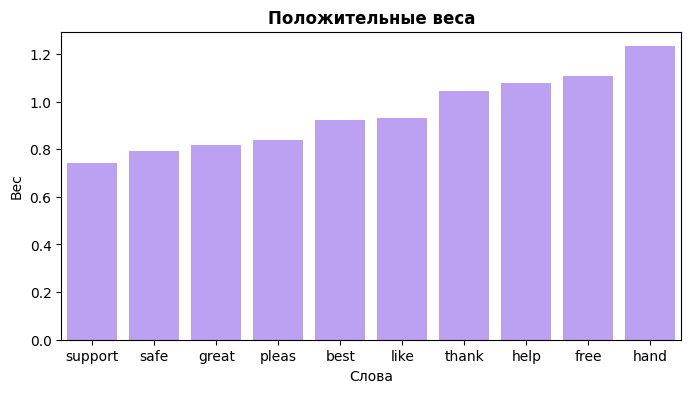

In [ ]:
# рисуем график для положительных весов
fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.barplot(tenpos, x="index", y=0, color='#B892FF')
ax.set(xlabel='Слова', ylabel='Вес')
ax.set_title('Положительные веса', weight='bold')

Токена получиились действительно положительно окрашенными в своем большистве: hand, free, help, thank, like, best, great и т.д. несут положительную окраску

Text(0.5, 1.0, 'Отрицательные веса')

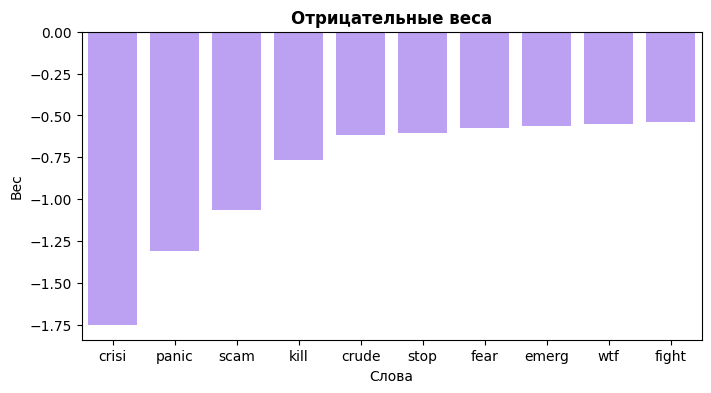

In [ ]:
# то же самое с отрицательными весами
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(tenneg, x="index", y=0, color='#B892FF')
ax.set(xlabel='Слова', ylabel='Вес')
ax.set_title('Отрицательные веса', weight='bold')

**Ответ:** здесь тоже получаются вполне окрашенные негативно токены: crisi(s), panic, scam, kill явно помогут определить, что у текста sentiment 0

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# посмотрим, сколько уникальных значений для каждого из признаков
X['UserName'].unique().shape

(33444,)

In [ ]:
X['ScreenName'].unique().shape

(33444,)

In [ ]:
# и сколько строк в выборке в целом
X.shape

(33444, 5)

**Ответ:** каждой строке в датафрейме соответствует отдельных username и screenname, поэтому этот признак представляет собой айди пользователя, не несет дополнительной информации об окраске твита, они бесполезны, их можно не учитывать

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# преобразуем к типу datetime
X_train['TweetAt'] = pd.to_datetime(X_train['TweetAt'], format='%d-%m-%Y')

In [ ]:
# объединим целевую переменную и признаки
frames = [X_train, y_train]

train = pd.concat(frames, axis=1)

Text(0.5, 1.0, 'Количество постов в определенный день')

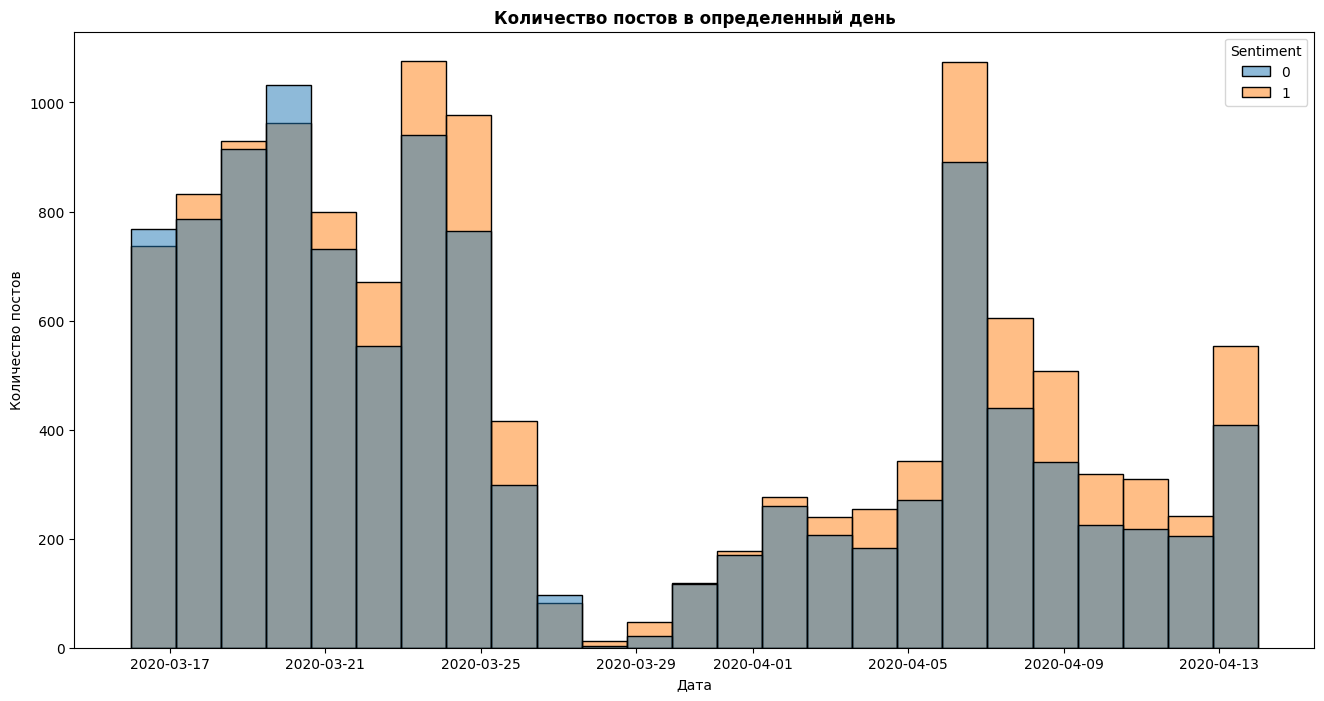

In [ ]:
# нарисуем гистограмму
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.histplot(data=train, x='TweetAt', stat='count',
                  hue='Sentiment')
ax.set(xlabel='Дата', ylabel='Количество постов')
ax.set_title('Количество постов в определенный день', weight='bold')

**Ответ:** в среднем можно сказать, что распределение этого признака для положительно и негативно окрашенных твитов схожее: часто просто в целом положительных больше. Не думаю, что этот признак может быть полезен. Кроме того, что важно, при получении новых данных модель будет работать неправильно: допустим, если ей дать новую дату 2024-05-13, то она совсем не будет знать, что делать, ведь этой даты даже близко нет в трейновой выборке. А новые посты всегда будут появляться с более поздней датой


Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# посмотрим количество уникальных значений
X_train['Location'].unique().shape

(7949,)

In [ ]:
# заодно сравним с общим числом строк в обучающей выборке
X_train.shape

(23410, 5)

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
# создадим словарь с частотой встречаемости локаций
locations = dict(X_train['Location'].value_counts())

In [ ]:
# удалим оттуда unknown
del locations['Unknown']

In [ ]:
# оставим 10 локаций
tenlocs = list(locations.keys())[:10]

values = {'count': {loc: locations[loc] for loc in tenlocs}}

In [ ]:
# создадим датафейм
locs = pd.DataFrame(values)
locs.reset_index(inplace=True)

In [ ]:
# посмотрим на полученный датафрейм
locs

,index,count
0,Australia,118
1,India,153
2,London,301
3,"London, England",274
4,"Los Angeles, CA",154
5,"New York, NY",223
6,UK,133
7,United Kingdom,204
8,United States,295
9,"Washington, DC",222


Text(0.5, 1.0, 'Количество постов в определенной локации')

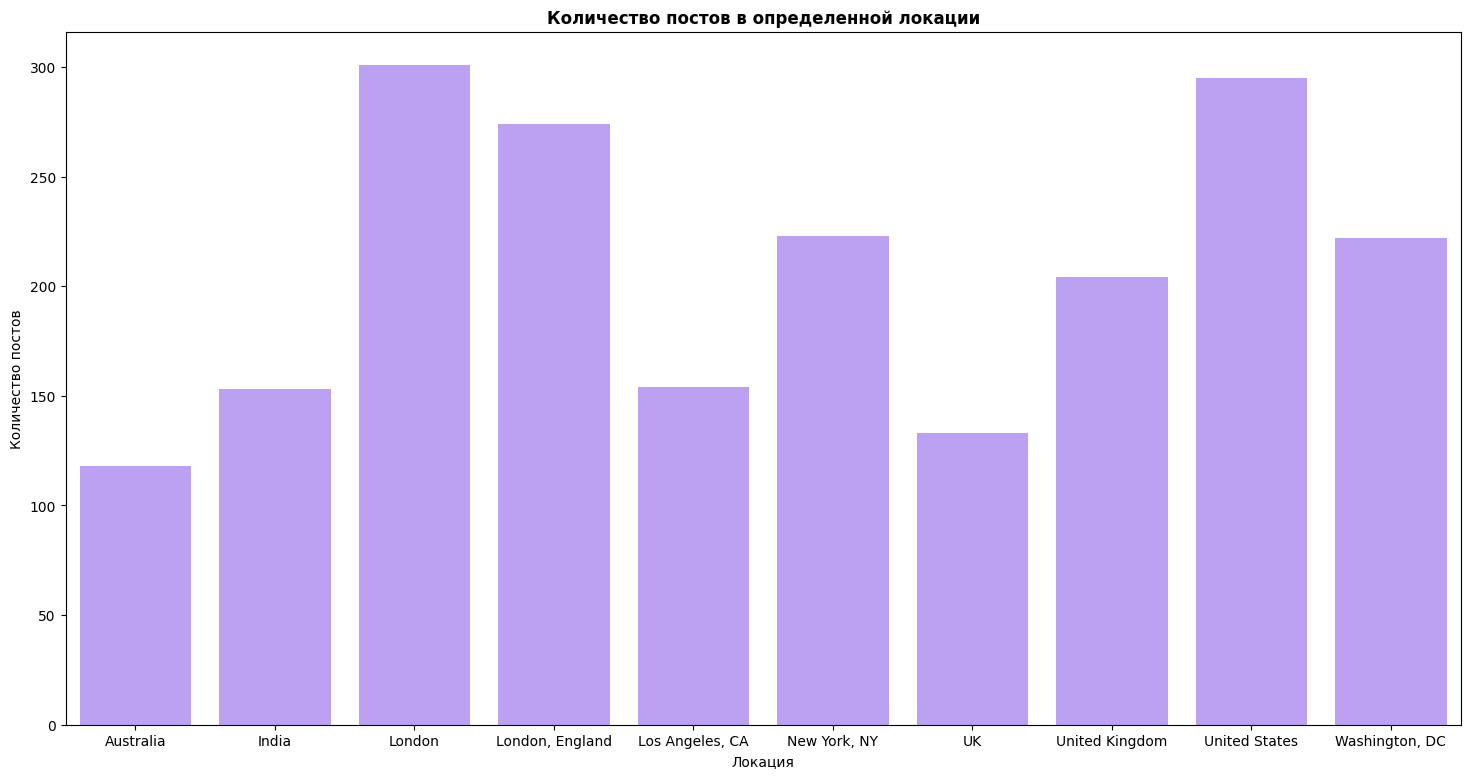

In [ ]:
# посмотрим график
fig, ax = plt.subplots(figsize=(18, 9))

ax = sns.barplot(locs, x='index', y='count', color='#B892FF')
ax.set(xlabel='Локация', ylabel='Количество постов')
ax.set_title('Количество постов в определенной локации', weight='bold')

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
# создаем признак: последнее слова после запятой
# трейн
X_train['WiderLocation'] = X_train['Location'].apply(lambda x: x.split(', ')[-1])

In [ ]:
# тест
X_test['WiderLocation'] = X_test['Location'].apply(lambda x: x.split(', ')[-1])

In [ ]:
# число уникальных категорий уменьшилось на 3000
X_train['WiderLocation'].unique().shape

(4921,)

In [ ]:
# делаем то же самое, что и выше
wlocations = dict(X_train['WiderLocation'].value_counts())

In [ ]:
del wlocations['Unknown']

In [ ]:
wtenlocs = list(wlocations.keys())[:10]

wvalues = {'count': {loc: wlocations[loc] for loc in wtenlocs}}

In [ ]:
wlocs = pd.DataFrame(wvalues)
wlocs.reset_index(inplace=True)

Text(0.5, 1.0, 'Количество постов в определенной локации')

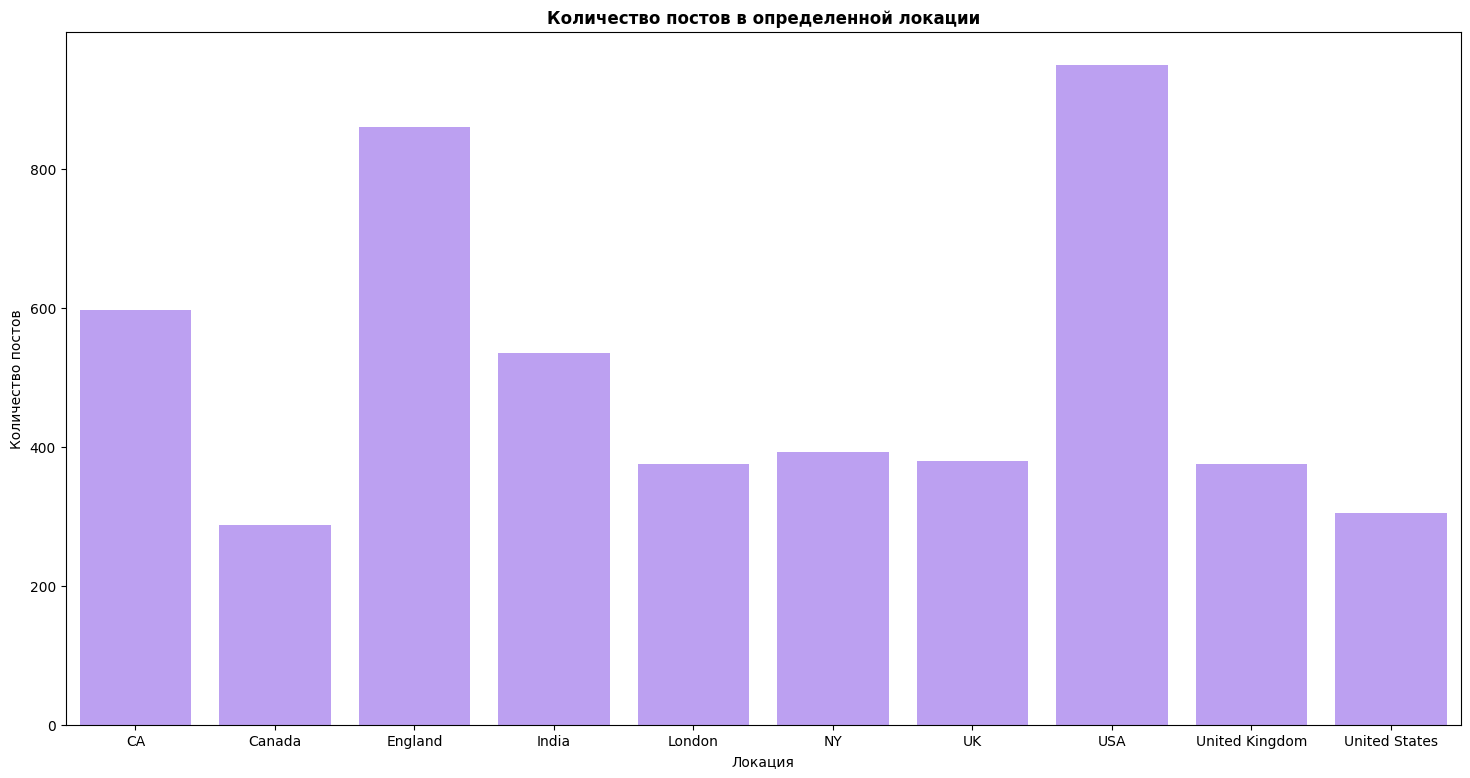

In [ ]:
fig, ax = plt.subplots(figsize=(18, 9))

ax = sns.barplot(wlocs, x='index', y='count', color='#B892FF')
ax.set(xlabel='Локация', ylabel='Количество постов')
ax.set_title('Количество постов в определенной локации', weight='bold')

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# кодируем при помощи ОНЕ
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# устанавливаем минимальную частоту встречаемости
enc = OneHotEncoder(min_frequency=2, handle_unknown = 'ignore')

In [ ]:
wlocation_df_tr = pd.DataFrame(X_train['WiderLocation'])

In [ ]:
wlocation_df_ts = pd.DataFrame(X_test['WiderLocation'])

In [ ]:
wloc_tr = enc.fit_transform(wlocation_df_tr)

In [ ]:
wloc_ts = enc.transform(wlocation_df_ts)

In [ ]:
# количество встречающихся минимум два раза локаций
enc.get_feature_names_out().shape

(1011,)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# соединяем матрицы
X_tr_sc = pd.DataFrame(X_train_scaled.toarray())

In [ ]:
w_loc_tr = pd.DataFrame(wloc_tr.toarray())

In [ ]:
X_train_fin = pd.concat([X_tr_sc, w_loc_tr], axis=1)

In [ ]:
X_ts_sc = pd.DataFrame(X_test_scaled.toarray())

In [ ]:
w_loc_ts = pd.DataFrame(wloc_ts.toarray())

In [ ]:
X_test_fin = pd.concat([X_ts_sc, w_loc_ts], axis=1)

In [ ]:
lr = LogisticRegression()

In [ ]:
# обучаем как всегда регрессию
lr.fit(X_train_fin, y_train)
lr_pred_test = lr.predict(X_test_fin)
lr_pred_train = lr.predict(X_train_fin)

acc_test = accuracy_score(y_test, lr_pred_test)
acc_train = accuracy_score(y_train, lr_pred_train)

print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9452370781717215
Доля правильных ответах на тесте: 0.8437313135339845


**Ответ:** Качество в целом изменилось не сильно: стало совсем незначительно меньше. Особого смысла этот признак использовать нет, потому что качество за счет него не растет

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

Методом долгих проб и ошибок оказалось, что с параметром class_weight='balanced' в логистической регрессии можно не заморачиваться особо с токенайзером: можно не чистить список токенов совсем, оставить пунктуацию, стоп-слова, ссылки странного вида, хештеги, странные символы с позицией в юникоде больше 128. Если убрать что-то из этого списка, то точность на тесте ухудшится. С одной стороны, сохранение пунктуации может быть логичным. Например, скобочки могут являться показателем реакции человека :( или :). А вот сохранение остальных штук -- это достаточно интересно. Но, по-видимому, все слова становятся взвешенными таким образом, что стоп-слова оказываются наравне со всеми другими (?)

In [ ]:
def new_tokenizer(text):
    tw = TweetTokenizer()
    tokens = tw.tokenize(text)
    return tokens

Векторайзер я тоже почти не меняла. Среди всех его возможных параметров важными оказалась даже не min_df или max_df (видимо, это тоже как-то связано с class_weight='balanced'), а просто приведение к нижнему регистру (можно было оставить в токенайзере), а также удаление странных символов юникода! Почему-то так работало лучше

In [ ]:
vec = CountVectorizer(tokenizer=new_tokenizer, lowercase=True, strip_accents='unicode')

In [ ]:
texts_tr = list(X_train['OriginalTweet'])
texts_ts = list(X_test['OriginalTweet'])

X_train_vec = vec.fit_transform(texts_tr)
X_test_vec = vec.transform(texts_ts)

Лучше было бы доказать, что такие параметры хорошо работают, при помощи GridSearchCV, и я честно пыталась вставить его в код, но оно работало больше 5 часов, а дедлайн приближался... Поэтому методом проб и ошибок было выяснено, что такой набор параметров (solver='liblinear', penalty='l1', intercept_scaling=1.4, C=2.5) работает очень хорошо (может, и не лучше всего). Видимо, при использовании L1 регуляризации некоторые слова зануляются (и это работает лучше фильтрации слов токенайзером!).

In [ ]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', penalty='l1', intercept_scaling=1.4, C=2.5)

In [ ]:
lr.fit(X_train_vec, y_train)

LogisticRegression(C=2.5, class_weight='balanced', intercept_scaling=1.4,
                   penalty='l1', random_state=42, solver='liblinear')

In [ ]:
pred_test = lr.predict(X_test_vec)
pred_train = lr.predict(X_train_vec)

acc_test = accuracy_score(y_test, pred_test)
acc_train = accuracy_score(y_train, pred_train)

print(f'Доля правильных ответах на трейне: {acc_train}')
print(f'Доля правильных ответах на тесте: {acc_test}')

Доля правильных ответах на трейне: 0.9973088423750534
Доля правильных ответах на тесте: 0.8939605341837752


Конечно, не 0.9, но, кажется, 0.88 тоже можно, так что ура-ура, можно сказать, что получилось!!